In [1]:
## Import libraries
import pandas as pd
import numpy as np
import math
import time

from helpers import readfile

In [2]:
# Read data
train_df = readfile('data', 'train.csv')
train_df.head()

//anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3248: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


,id,date,store_nbr,item_nbr,unit_sales,onpromotion
0,0,2013-01-01,25,103665,7.0,NaN
1,1,2013-01-01,25,105574,1.0,NaN
2,2,2013-01-01,25,105575,2.0,NaN
3,3,2013-01-01,25,108079,1.0,NaN
4,4,2013-01-01,25,108701,1.0,NaN


In [3]:
print(f'Training Dataset has {len(train_df)} rows before filtering.')

Training Dataset has 125497040 rows before filtering.


In [4]:
# Filter training data by date range ()
train_df = train_df[(train_df['date'] >= '2015-01-01') & (train_df['date'] <= '2018-01-01')]

In [5]:
test_df = readfile('data', 'test.csv')
test_df.head()

,id,date,store_nbr,item_nbr,onpromotion
0,125497040,2017-08-16,1,96995,False
1,125497041,2017-08-16,1,99197,False
2,125497042,2017-08-16,1,103501,False
3,125497043,2017-08-16,1,103520,False
4,125497044,2017-08-16,1,103665,False


In [6]:
print(f'Training Dataset has {len(train_df)} rows after filtering.')
print(f'Test Dataset has {len(test_df)} rows.')

Training Dataset has 86902776 rows after filtering.
Test Dataset has 3370464 rows.


### Reduce Prediction Scope

In [7]:
store_nbr = 44
train_df = train_df[(train_df['store_nbr'] == store_nbr)]
# train_df = train_df[(train_df['item_nbr'] == item_nbr) & (train_df['store_nbr'] == store_nbr)]

print(f'Training Dataset has {len(train_df)} rows after filtering to store {store_nbr}.')

Training Dataset has 2364891 rows after filtering to store 44.


In [8]:
train_df.head()

,id,date,store_nbr,item_nbr,unit_sales,onpromotion
38641037,38641037,2015-01-02,44,103520,10.0,False
38641038,38641038,2015-01-02,44,103665,6.0,False
38641039,38641039,2015-01-02,44,105574,28.0,False
38641040,38641040,2015-01-02,44,105575,52.0,False
38641041,38641041,2015-01-02,44,105577,6.0,False


#### Helper functions

In [9]:
# Lookback time feature
def add_time_diff(df, ori_col, shift_count):
    shift = df[ori_col].shift(shift_count)
    new_col = ori_col + str(shift_count)
    df[new_col] = shift
    return df

In [10]:
def rmse(y, yhat):
    return math.sqrt(np.mean((yhat - y) ** 2))

#### Feature Engineering (XGBoost)

In [11]:
# train_dataset = pd.read_csv('data/train.csv', nrows=10000)
train_dataset = train_df.copy()

In [12]:
train_dataset.head(10)

,id,date,store_nbr,item_nbr,unit_sales,onpromotion
38641037,38641037,2015-01-02,44,103520,10.0,False
38641038,38641038,2015-01-02,44,103665,6.0,False
38641039,38641039,2015-01-02,44,105574,28.0,False
38641040,38641040,2015-01-02,44,105575,52.0,False
38641041,38641041,2015-01-02,44,105577,6.0,False
38641042,38641042,2015-01-02,44,105693,8.0,False
38641043,38641043,2015-01-02,44,106716,17.0,False
38641044,38641044,2015-01-02,44,108079,4.0,False
38641045,38641045,2015-01-02,44,108634,15.0,False
38641046,38641046,2015-01-02,44,108696,5.0,True


In [148]:
def preprocess_data(train_dataset):
    print('Loading dataset')
    holidays_dataset = readfile('data', 'holidays_events.csv')
    item_dataset = readfile('data', 'items.csv')
    store_dataset = readfile('data', 'stores.csv')
    oil_dataset = readfile('data', 'oil.csv')

    min_date = min(train_dataset['date'])
    max_date = max(train_dataset['date'])
    # Create new DataFrame to take into account missing data
    date_range = pd.date_range(start=min_date, end=max_date, freq='D')
    date_range[:10]

    train_df = pd.DataFrame(date_range, columns=['date'])
    train_df['unit_sales'] = 0

    train_dataset['date'] = pd.to_datetime(train_dataset['date'])
    train_df = train_df.merge(train_dataset, how='left', on='date').drop(['unit_sales_x'], axis=1).fillna(0)
    train_df.rename(columns={'unit_sales_y': 'unit_sales'}, inplace=True)

    for day in range(1,8):
        train_df = add_time_diff(train_df, 'unit_sales', day)

    # Get date features
    train_df['year'] = train_df['date'].dt.year
    train_df['day_of_year'] = train_df['date'].dt.dayofyear
    train_df['day_of_week'] = train_df['date'].dt.weekday
    train_df['week_of_year'] = train_df['date'].dt.week
    train_df['day_of_month'] = train_df['date'].dt.day
    train_df['quarter'] = train_df['date'].dt.quarter

    # Get holiday features
    holidays_dataset['date'] = pd.to_datetime(holidays_dataset['date'])
    holidays_dataset = pd.get_dummies(holidays_dataset, columns=['locale','locale_name', 'type'], prefix=['locale','locale_name', 'holiday_type'])
    holidays_dataset = holidays_dataset.drop(columns=['description','transferred'])
    train_df = train_df.merge(holidays_dataset, how='left', on='date')
    train_df.rename(columns={'type': 'holiday_type'}, inplace=True)

    # Get item features
    item_dataset = pd.get_dummies(item_dataset, columns=['family'], prefix=['family'])
    item_dataset = item_dataset.drop(columns=['class'])
    train_df = train_df.merge(item_dataset, how='left', on='item_nbr')

    # Get store features
    store_dataset['city_state'] = store_dataset[['city', 'state']].apply(lambda x: '_'.join(x), axis=1)
    store_dataset = pd.get_dummies(store_dataset, columns=['city_state', 'type'], prefix=['city_state', 'store_type'])
    store_dataset = store_dataset.drop(columns=['city', 'state'])
    train_df = train_df.merge(store_dataset, how='left', on='store_nbr')
    train_df.rename(columns={'type': 'location_type'}, inplace=True)

    # Get oil features
    oil_dataset['date'] = pd.to_datetime(oil_dataset['date'])
    oil_dataset = oil_dataset.sort_values(by=['date'], ascending=[True])
    oil_dataset.set_index('date', inplace=True)
    oil_dataset = oil_dataset.resample('D').ffill().reset_index()
    train_df = train_df.merge(oil_dataset, how='left', on='date')

    # Log unit sales
    train_df['unit_sales'] = train_df['unit_sales'].map(lambda x: np.log1p(float(x)) if float(x) > 0 else 0)

    # Drop unused columns
    train_df.drop(columns=['date', 'id', 'onpromotion'], inplace=True)

    print('@create_dataset - done with preprocess (XGBoost)')
    return train_df

In [149]:
xgb_train_df = preprocess_data(train_dataset)

Loading dataset
@create_dataset - done with preprocess (XGBoost)


In [150]:
xgb_train_df.head()

,store_nbr,item_nbr,unit_sales,unit_sales1,unit_sales2,unit_sales3,unit_sales4,unit_sales5,unit_sales6,unit_sales7,...,city_state_Quito_Pichincha,city_state_Riobamba_Chimborazo,city_state_Salinas_Santa Elena,city_state_Santo Domingo_Santo Domingo de los Tsachilas,store_type_A,store_type_B,store_type_C,store_type_D,store_type_E,dcoilwtico
0,44.0,103520.0,2.397895,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,52.72
1,44.0,103665.0,1.945910,10.0,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,52.72
2,44.0,105574.0,3.367296,6.0,10.0,NaN,NaN,NaN,NaN,NaN,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,52.72
3,44.0,105575.0,3.970292,28.0,6.0,10.0,NaN,NaN,NaN,NaN,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,52.72
4,44.0,105577.0,1.945910,52.0,28.0,6.0,10.0,NaN,NaN,NaN,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,52.72


In [151]:
print(f'Number of features after feature engineering (XGBoost): {len(xgb_train_df.columns)}\n')
print(xgb_train_df.columns)

Number of features after feature engineering (XGBoost): 112

Index(['store_nbr', 'item_nbr', 'unit_sales', 'unit_sales1', 'unit_sales2',
       'unit_sales3', 'unit_sales4', 'unit_sales5', 'unit_sales6',
       'unit_sales7',
       ...
       'city_state_Quito_Pichincha', 'city_state_Riobamba_Chimborazo',
       'city_state_Salinas_Santa Elena',
       'city_state_Santo Domingo_Santo Domingo de los Tsachilas',
       'store_type_A', 'store_type_B', 'store_type_C', 'store_type_D',
       'store_type_E', 'dcoilwtico'],
      dtype='object', length=112)


#### Feature Engineering (CatBoost/LightGBM)

In [13]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

In [14]:
def catboost_lgbm_preprocess_data(train_dataset):
    print('Loading dataset')
    holidays_dataset = readfile('data', 'holidays_events.csv')
    item_dataset = readfile('data', 'items.csv')
    store_dataset = readfile('data', 'stores.csv')
    oil_dataset = readfile('data', 'oil.csv')

    min_date = min(train_dataset['date'])
    max_date = max(train_dataset['date'])
    # Create new DataFrame to take into account missing data
    date_range = pd.date_range(start=min_date, end=max_date, freq='D')
    date_range[:10]

    train_df = pd.DataFrame(date_range, columns=['date'])
    train_df['unit_sales'] = 0

    train_dataset['date'] = pd.to_datetime(train_dataset['date'])
    train_df = train_df.merge(train_dataset, how='left', on='date').drop(['unit_sales_x'], axis=1).fillna(0)
    train_df.rename(columns={'unit_sales_y': 'unit_sales'}, inplace=True)

    for day in range(1,8):
        train_df = add_time_diff(train_df, 'unit_sales', day)
    # LightGBM/CatBoost cannot handle NaN
    train_df.update(train_df[['unit_sales1', 'unit_sales2',
       'unit_sales3', 'unit_sales4', 'unit_sales5', 'unit_sales6',
       'unit_sales7']].fillna(0))

    # Get date features
    train_df['year'] = train_df['date'].dt.year
    train_df['day_of_year'] = train_df['date'].dt.dayofyear
    train_df['day_of_week'] = train_df['date'].dt.weekday
    train_df['week_of_year'] = train_df['date'].dt.week
    train_df['day_of_month'] = train_df['date'].dt.day
    train_df['quarter'] = train_df['date'].dt.quarter
    
    # Get sin/cos features
    week_of_year = train_df['date'].dt.weekofyear
    week_of_year_sin = np.sin(2 * np.pi * week_of_year / 53)
    week_of_year_cos = np.cos(2 * np.pi * week_of_year / 53)
    train_df['week_of_year_sin'] = week_of_year_sin
    train_df['week_of_year_cos'] = week_of_year_cos
    
    daysinweek = 7
    day_of_week = train_df['date'].dt.dayofweek
    day_of_week_sin = np.sin(2 * np.pi * day_of_week / daysinweek)
    day_of_week_cos = np.cos(2 * np.pi * day_of_week / daysinweek)
    train_df['day_of_week_sin'] = day_of_week_sin
    train_df['day_of_week_cos'] = day_of_week_cos

    # Get holiday features
    holidays_dataset['date'] = pd.to_datetime(holidays_dataset['date'])
    holidays_dataset = holidays_dataset.drop(columns=['description','transferred'])
    train_df = train_df.merge(holidays_dataset, how='left', on='date')
    for (columnName, columnData) in train_df.iteritems():
        if columnName in ['locale', 'locale_name', 'type']:
            train_df[columnName] = train_df[columnName].fillna('nan')
    
    train_df['locale'] = le.fit_transform(train_df['locale'])
    train_df['locale_name'] = le.fit_transform(train_df['locale_name'])
    train_df['type'] = le.fit_transform(train_df['type'])
    train_df.rename(columns={'type': 'holiday_type'}, inplace=True)

    # Get item features
    item_dataset = item_dataset.drop(columns=['class'])
    train_df = train_df.merge(item_dataset, how='left', on='item_nbr')
    for (columnName, columnData) in train_df.iteritems():
        if columnName in ['family']:
            train_df[columnName] = train_df[columnName].fillna('nan')
    for (columnName, columnData) in train_df.iteritems():
        if columnName in ['perishable']:
            train_df[columnName]= train_df[columnName].fillna(0)
    train_df['family'] = le.fit_transform(train_df['family'])
    

    # Get store features
    store_dataset['city_state'] = store_dataset[['city', 'state']].apply(lambda x: '_'.join(x), axis=1)
    store_dataset = store_dataset.drop(columns=['city', 'state'])
    train_df = train_df.merge(store_dataset, how='left', on='store_nbr')
    for (columnName, columnData) in train_df.iteritems():
        if columnName in ['city_state', 'type']:
            train_df[columnName] = train_df[columnName].fillna('nan')
    for (columnName, columnData) in train_df.iteritems():
        if columnName in ['cluster']:
            train_df[columnName] = train_df[columnName].fillna(0)
    
    train_df['city_state'] = le.fit_transform(train_df['city_state'])
    train_df['type'] = le.fit_transform(train_df['type'])
    
    train_df.rename(columns={'type': 'location_type'}, inplace=True)

    # Get oil features
    oil_dataset['date'] = pd.to_datetime(oil_dataset['date'])
    oil_dataset = oil_dataset.sort_values(by=['date'], ascending=[True])
    oil_dataset.set_index('date', inplace=True)
    oil_dataset = oil_dataset.resample('D').ffill().reset_index()
    oil_dataset.update(
        oil_dataset[[
            'dcoilwtico'
        ]]
    .fillna(0))
    
    train_df = train_df.merge(oil_dataset, how='left', on='date')

    # Log unit sales
    train_df['unit_sales'] = train_df['unit_sales'].map(lambda x: np.log1p(float(x)) if float(x) > 0 else 0)
    
    # Drop unused columns
    train_df.drop(columns=['date', 'id', 'onpromotion'], inplace=True)

    print('@create_dataset - done with preprocess (CatBoost/LightGBM)')
    return train_df

In [15]:
cat_lgbm_train_df = catboost_lgbm_preprocess_data(train_dataset)

Loading dataset
@create_dataset - done with preprocess (CatBoost/LightGBM)


In [16]:
cat_lgbm_train_df.head(10)

,store_nbr,item_nbr,unit_sales,unit_sales1,unit_sales2,unit_sales3,unit_sales4,unit_sales5,unit_sales6,unit_sales7,...,day_of_week_cos,holiday_type,locale,locale_name,family,perishable,location_type,cluster,city_state,dcoilwtico
0,44.0,103520.0,2.397895,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.900969,1,1,4,11,0.0,0,5.0,0,52.72
1,44.0,103665.0,1.945910,10.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.900969,1,1,4,4,1.0,0,5.0,0,52.72
2,44.0,105574.0,3.367296,6.0,10.0,0.0,0.0,0.0,0.0,0.0,...,-0.900969,1,1,4,11,0.0,0,5.0,0,52.72
3,44.0,105575.0,3.970292,28.0,6.0,10.0,0.0,0.0,0.0,0.0,...,-0.900969,1,1,4,11,0.0,0,5.0,0,52.72
4,44.0,105577.0,1.945910,52.0,28.0,6.0,10.0,0.0,0.0,0.0,...,-0.900969,1,1,4,11,0.0,0,5.0,0,52.72
5,44.0,105693.0,2.197225,6.0,52.0,28.0,6.0,10.0,0.0,0.0,...,-0.900969,1,1,4,11,0.0,0,5.0,0,52.72
6,44.0,106716.0,2.890372,8.0,6.0,52.0,28.0,6.0,10.0,0.0,...,-0.900969,1,1,4,11,0.0,0,5.0,0,52.72
7,44.0,108079.0,1.609438,17.0,8.0,6.0,52.0,28.0,6.0,10.0,...,-0.900969,1,1,4,11,0.0,0,5.0,0,52.72
8,44.0,108634.0,2.772589,4.0,17.0,8.0,6.0,52.0,28.0,6.0,...,-0.900969,1,1,4,11,0.0,0,5.0,0,52.72
9,44.0,108696.0,1.791759,15.0,4.0,17.0,8.0,6.0,52.0,28.0,...,-0.900969,1,1,4,8,1.0,0,5.0,0,52.72


In [17]:
print(f'Number of features after feature engineering (CatBoost/LightGBM): {len(cat_lgbm_train_df.columns)}\n')
print(cat_lgbm_train_df.columns)

Number of features after feature engineering (CatBoost/LightGBM): 29

Index(['store_nbr', 'item_nbr', 'unit_sales', 'unit_sales1', 'unit_sales2',
       'unit_sales3', 'unit_sales4', 'unit_sales5', 'unit_sales6',
       'unit_sales7', 'year', 'day_of_year', 'day_of_week', 'week_of_year',
       'day_of_month', 'quarter', 'week_of_year_sin', 'week_of_year_cos',
       'day_of_week_sin', 'day_of_week_cos', 'holiday_type', 'locale',
       'locale_name', 'family', 'perishable', 'location_type', 'cluster',
       'city_state', 'dcoilwtico'],
      dtype='object')


### Tree-Based Modeling

In [19]:
from sklearn.model_selection import train_test_split

In [ ]:
X = xgb_train_df.drop('unit_sales', axis=1)
y = xgb_train_df.unit_sales

# To split train-test set by date
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.3,
    random_state=1,
    shuffle=False
)

X_train, X_validation, y_train, y_validation = train_test_split(
    X_train,
    y_train,
    test_size=0.3,
    random_state=1,
    shuffle=False
)

print(f'Length of training and validation sets:\n \
X_train: {len(X_train)}\n \
y_train: {len(y_train)}\n \
X_validation: {len(X_validation)}\n \
y_validation: {len(y_validation)}\n \
X_test: {len(X_test)}\n \
y_test: {len(y_test)}\n')

#### XGBoost

In [ ]:
import xgboost
from xgboost import XGBRegressor
# from sklearn.grid_search import GridSearchCV

# XGBoost model
xgb_model = xgboost.XGBRegressor(
    learning_rate=0.05,
    max_depth=15,
    n_estimators=10000,
    objective='reg:squarederror',
    eval_metric='rmse'
)

fit_params={
    "early_stopping_rounds": 50
}
# xgb_model = xgboost.XGBRegressor(
#     colsample_bytree=0.4,
#     gamma=0,                 
#     learning_rate=0.05,
#     max_depth=20,
#     min_child_weight=1.5,
#     n_estimators=10000,                                                                    
#     reg_alpha=0.75,
#     reg_lambda=0.45,
#     subsample=0.6,
#     seed=42,
#     objective='reg:squarederror',
#     eval_metric='rmse'
# )

start_time = time.time()
xgb_model.fit(
    X_train,
    y_train
)
print("--- %s seconds ---" % (time.time() - start_time))

//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


In [ ]:
start_time = time.time()
preds = xgb_model.predict(X_test)
print("RMSE: %.2f" % rmse(preds, y_test))
print("--- %s seconds ---" % (time.time() - start_time))

#### Catboost

In [20]:
X = cat_lgbm_train_df.drop('unit_sales', axis=1)
y = cat_lgbm_train_df.unit_sales

# To split train-test set by date
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.3,
    random_state=1,
    shuffle=False
)

X_train, X_validation, y_train, y_validation = train_test_split(
    X_train,
    y_train,
    test_size=0.3,
    random_state=1,
    shuffle=False
)

print(f'Length of training and validation sets:\n \
X_train: {len(X_train)}\n \
y_train: {len(y_train)}\n \
X_validation: {len(X_validation)}\n \
y_validation: {len(y_validation)}\n \
X_test: {len(X_test)}\n \
y_test: {len(y_test)}\n')

Length of training and validation sets:
 X_train: 1183387
 y_train: 1183387
 X_validation: 507166
 y_validation: 507166
 X_test: 724524
 y_test: 724524



In [ ]:
print(X_train.isna().any())

In [46]:
# Category features (Used in both CatBoost & LightGBM)
cat_features = [
    'item_nbr', 'year', 'day_of_year', 'day_of_week', 'week_of_year', 'day_of_month', 'quarter',
    'holiday_type', 'locale', 'locale_name', 'family', 'perishable',
    'location_type', 'cluster', 'city_state'
]

In [47]:
from catboost import CatBoostRegressor

## Catboost model
catboost_model = CatBoostRegressor(
    one_hot_max_size=10,
    iterations=60,
    depth=15,
    learning_rate=0.05,
    loss_function='RMSE',
    od_type='Iter',
    od_wait=100
)

start_time = time.time()
catboost_model.fit(
    X_train,
    y_train,
    eval_set=(X_validation, y_validation),
    plot=True,
    use_best_model=True,
    cat_features=cat_features
)
print("--- %s seconds ---" % (time.time() - start_time))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 2.4212525	test: 2.3908746	best: 2.3908746 (0)	total: 1.82s	remaining: 1m 47s
1:	learn: 2.3171777	test: 2.2866920	best: 2.2866920 (1)	total: 3.58s	remaining: 1m 43s
2:	learn: 2.2195895	test: 2.1890370	best: 2.1890370 (2)	total: 5.16s	remaining: 1m 37s
3:	learn: 2.1273309	test: 2.0970275	best: 2.0970275 (3)	total: 6.66s	remaining: 1m 33s
4:	learn: 2.0402486	test: 2.0108108	best: 2.0108108 (4)	total: 7.99s	remaining: 1m 27s
5:	learn: 1.9584612	test: 1.9295776	best: 1.9295776 (5)	total: 9.43s	remaining: 1m 24s
6:	learn: 1.8815384	test: 1.8532385	best: 1.8532385 (6)	total: 10.9s	remaining: 1m 22s
7:	learn: 1.8090664	test: 1.7806949	best: 1.7806949 (7)	total: 11.2s	remaining: 1m 12s
8:	learn: 1.7409287	test: 1.7131488	best: 1.7131488 (8)	total: 12.7s	remaining: 1m 11s
9:	learn: 1.6773889	test: 1.6555800	best: 1.6555800 (9)	total: 14.1s	remaining: 1m 10s
10:	learn: 1.6176369	test: 1.5969799	best: 1.5969799 (10)	total: 15.7s	remaining: 1m 9s
11:	learn: 1.5617044	test: 1.5414539	best:

In [48]:
start_time = time.time()
preds = catboost_model.predict(X_test)
print("--- %s seconds ---" % (time.time() - start_time))
print("RMSLE: %.2f" % rmse(preds, y_test))

--- 7.034056901931763 seconds ---
RMSLE: 0.71


#### LightGBM

In [49]:
import lightgbm as lgb

## LightGBM model
# LightGBM dataset formatting 
lgtrain = lgb.Dataset(X_train, y_train)
lgvalid = lgb.Dataset(X_validation, y_validation)

params = {
    'objective' : 'regression',
    'metric' : 'rmse',
    'num_leaves' : 200,
    'max_depth': 15,
    'learning_rate' : 0.05,
    'feature_fraction' : 0.6,
    'verbosity' : -1
}

start_time = time.time()
lgb_model = lgb.train(
    params,
    lgtrain,
    num_boost_round=10000,
    valid_sets=[lgtrain, lgvalid],
    valid_names=["train", "valid"],
    early_stopping_rounds=50,
    verbose_eval=500,
    categorical_feature=cat_features
)
print("--- %s seconds ---" % (time.time() - start_time))
# print("RMSE of the validation set:", np.sqrt(mean_squared_error(y_valid, lgb_clf.predict(X_valid))))

//anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1188: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['city_state', 'cluster', 'day_of_month', 'day_of_week', 'day_of_year', 'family', 'holiday_type', 'item_nbr', 'locale', 'locale_name', 'location_type', 'perishable', 'quarter', 'week_of_year', 'year']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
//anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[500]	train's rmse: 0.47987	valid's rmse: 0.592542
Early stopping, best iteration is:
[629]	train's rmse: 0.468158	valid's rmse: 0.592284
--- 83.65181994438171 seconds ---


In [50]:
start_time = time.time()
preds = lgb_model.predict(X_test)
print("--- %s seconds ---" % (time.time() - start_time))
print("RMSLE: %.2f" % rmse(preds, y_test))

--- 61.747193813323975 seconds ---
RMSLE: 0.67


In [51]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_feature_importance(model, X, num=20):
    feature_imp = pd.DataFrame({'Value':model.feature_importance(),'Feature':X.columns})
    plt.figure(figsize=(40, 20))
    sns.set(font_scale = 5)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", 
                                                        ascending=False)[0:num])
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.savefig('lgbm_importances-01.png')
    plt.show()

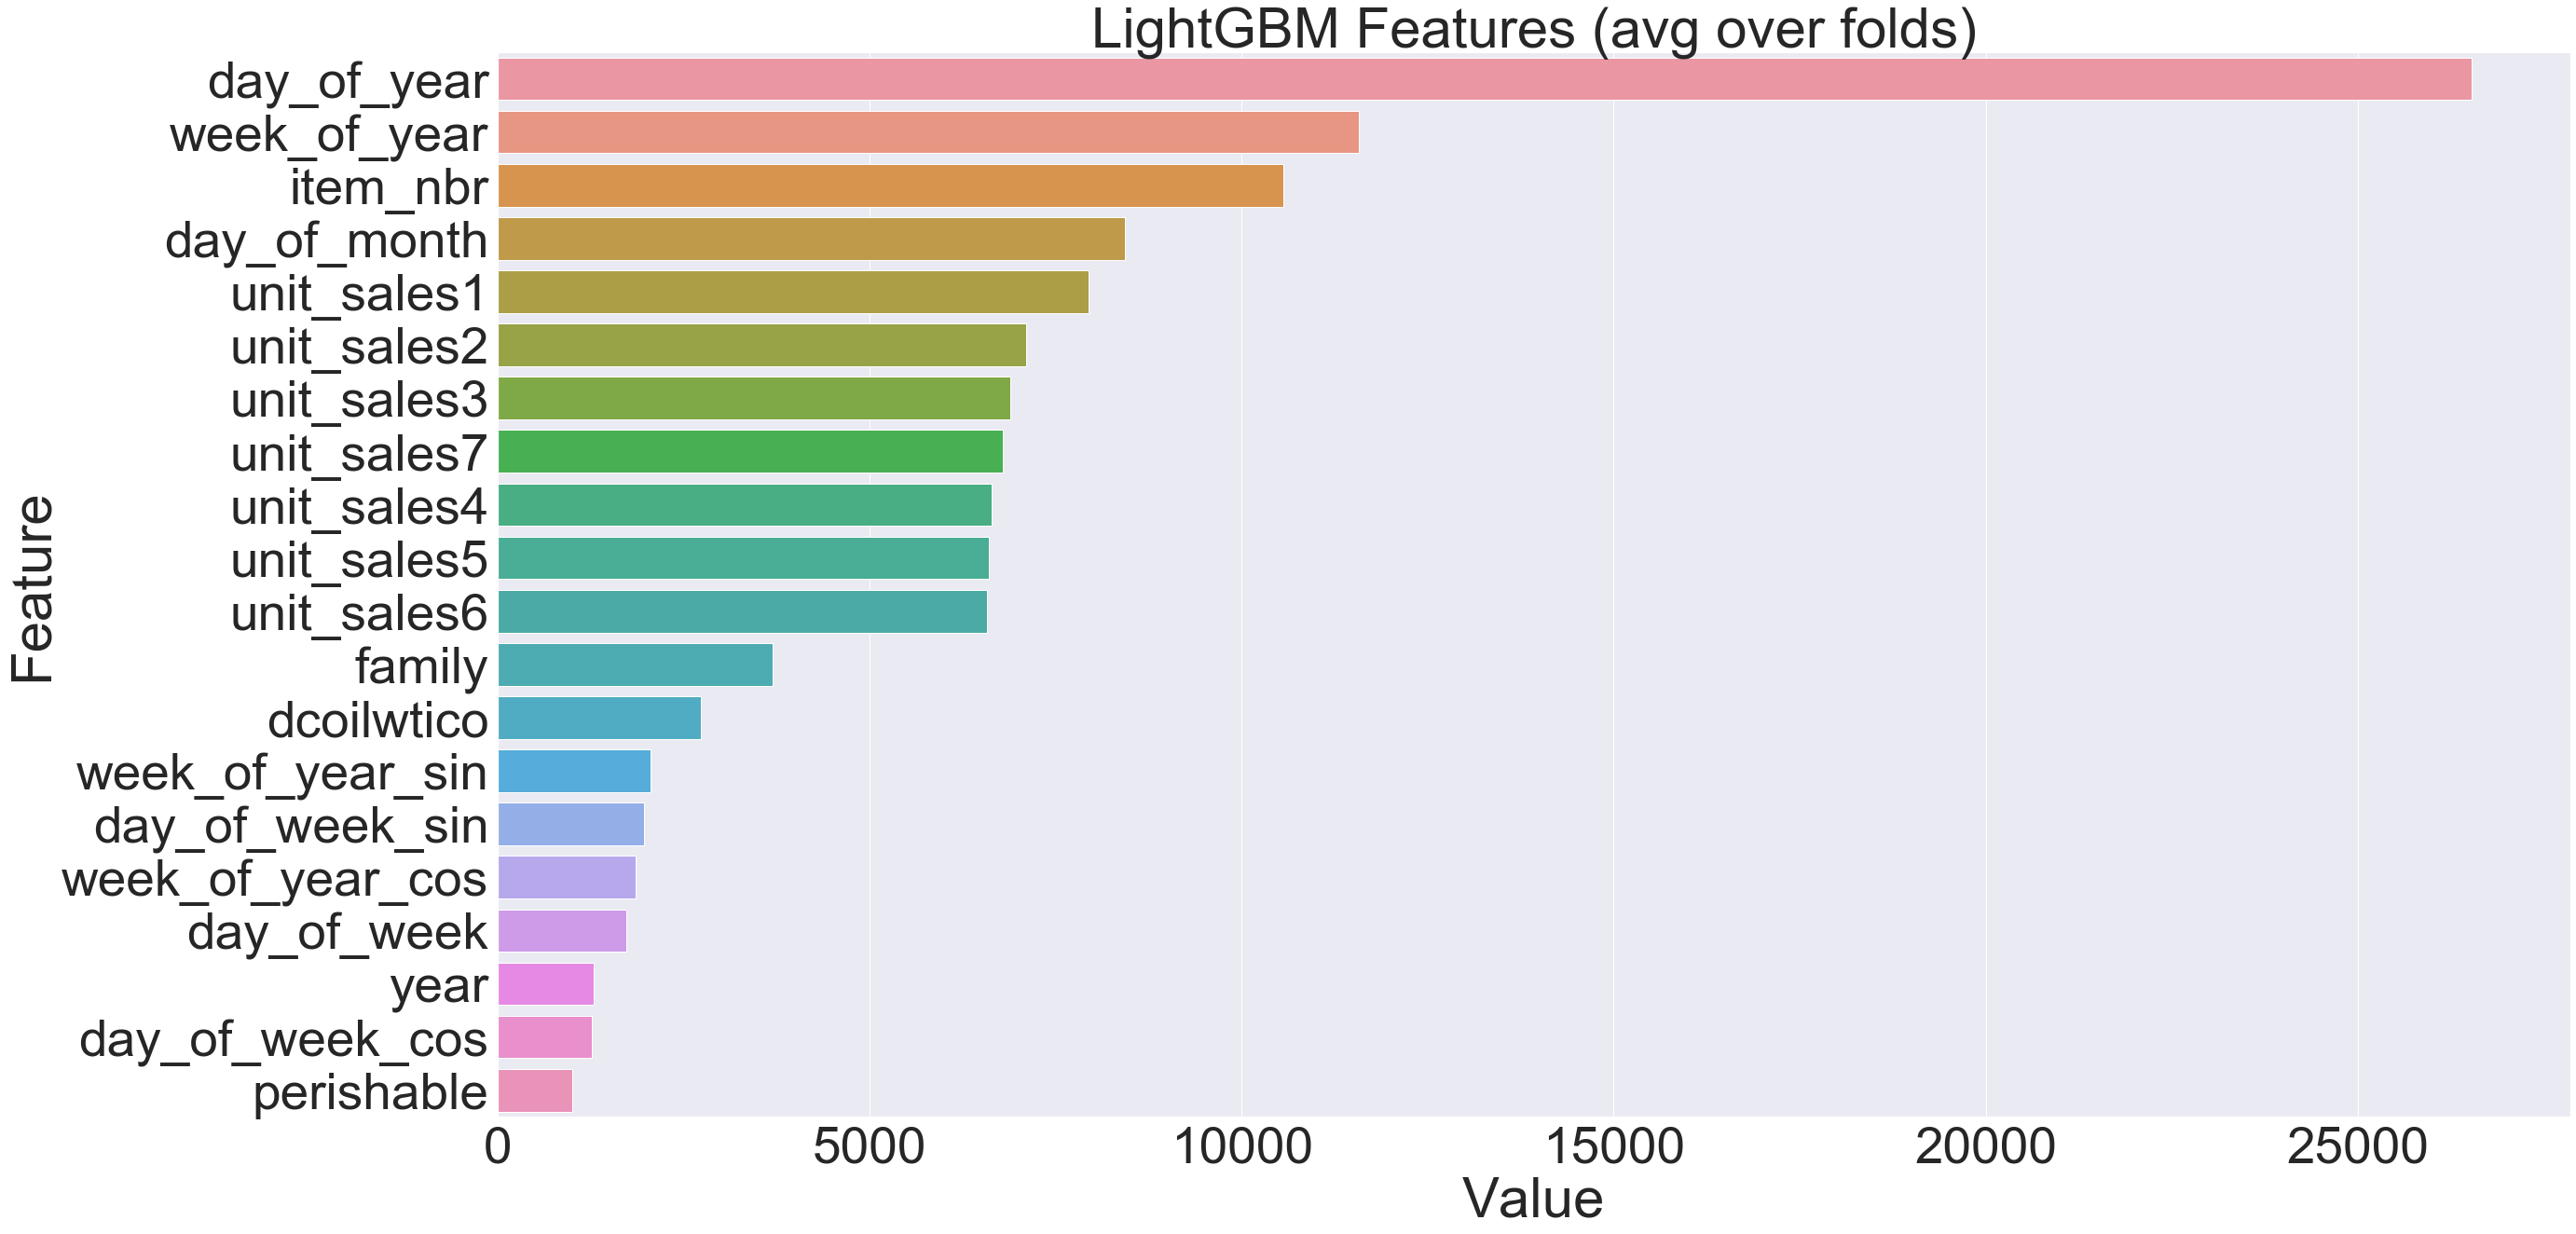

In [52]:
plot_feature_importance(lgb_model, X_test)

In [30]:
from sklearn.ensemble import RandomForestRegressor

clf = RandomForestRegressor(n_estimators=200, max_depth=10, random_state=0)
start_time = time.time()
clf.fit(X_train, y_train)
print("--- %s seconds ---" % (time.time() - start_time))

--- 1161.3784430027008 seconds ---


In [31]:
start_time = time.time()
preds = clf.predict(X_test)
print("--- %s seconds ---" % (time.time() - start_time))

--- 7.094188928604126 seconds ---


In [32]:
print("RMSE: %.2f" % rmse(preds, y_test))

RMSE: 0.88
